# Decoding Social Intent from Neural Oscillations
## Exploratory Data Analysis

**COGS 118C — Signal Processing Course Project**

**Research Question:** Can we classify whether an animal is interacting socially vs. exploring alone based on the spectral features of its neural calcium signals?

---

### Goals of this notebook

1. **Download & load** the three core datasets: calcium traces, behavioral labels, session metadata
2. **Inspect** data shapes, sampling rates, and quality across all 18 sessions
3. **Visualize** raw calcium signals with behavioral epoch overlays
4. **Preliminary spectral analysis** — PSD, spectrograms, wavelets
5. **Compare** spectral features between social vs. solo epochs
6. **Sanity-check classification** with permutation test

### Data sources

| File | Format | Content |
|------|--------|---------|
| `calcium.00.h5` | HDF5 | 18 sessions of calcium traces (`C` key, frames x neurons), **30 fps** |
| `social_bouts.00.h5` | HDF5 | 18 sessions of boolean behavioral labels, **25 fps** |
| `SI3_2022_Entrance_Frames.xlsx` | Excel | Session metadata (animal, isolation condition, entry frame) |

---
## 1. Setup & Dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
from pathlib import Path

from scipy.signal import welch, butter, filtfilt, stft
from scipy.stats import mannwhitneyu
import pywt

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, roc_auc_score

from tqdm import tqdm

sns.set_theme(style='whitegrid', context='notebook', font_scale=1.1)
plt.rcParams['figure.figsize'] = (14, 5)
plt.rcParams['figure.dpi'] = 100
np.random.seed(42)
print('All imports successful.')

All imports successful.


---
## 2. Data Download & Loading

Three files from Google Drive, downloaded with `gdown`. The Drive file IDs were extracted from the EDGE source notebooks.

In [2]:
import gdown

DATA_DIR = Path('../data/raw')
DATA_DIR.mkdir(parents=True, exist_ok=True)

FILES = {
    'calcium.00.h5':                 '1UthpsskvkHbKKDsbQjUxyVN4Xkd-ZJuN',   # ~250 MB
    'social_bouts.00.h5':            '1Mh8oGKNyKpT5WS0Wu92SULFFanvqmSMf',   # ~510 KB
    'SI3_2022_Entrance_Frames.xlsx': '1POpRqpA_QaWfZhxswQvLSs9uBnnHrmhZ',   # ~10 KB
}

for filename, file_id in FILES.items():
    out_path = DATA_DIR / filename
    if out_path.exists():
        size_mb = out_path.stat().st_size / 1024 / 1024
        print(f'  [skip] {filename} ({size_mb:.1f} MB)')
    else:
        print(f'  Downloading {filename}...')
        gdown.download(f'https://drive.google.com/uc?id={file_id}', str(out_path), quiet=False)
        size_mb = out_path.stat().st_size / 1024 / 1024
        print(f'  [ok] {filename} ({size_mb:.1f} MB)')

  [skip] calcium.00.h5 (238.6 MB)
  [skip] social_bouts.00.h5 (0.5 MB)
  [skip] SI3_2022_Entrance_Frames.xlsx (0.0 MB)


### 2.1 Load session metadata

In [3]:
entrances = pd.read_excel(DATA_DIR / 'SI3_2022_Entrance_Frames.xlsx')
n_sessions = len(entrances)

print(f'Sessions: {n_sessions}')
print(f'Columns: {list(entrances.columns)}')
print(f'\nIsolation conditions:')
print(entrances['Isolation Length'].value_counts().to_string())
print()
entrances

Sessions: 18
Columns: ['Date', 'Session', 'Isolation Length', 'Animal', 'Task', 'Int_Entry', 'End', 'Frame Rate']

Isolation conditions:
Isolation Length
24hr         6
7d           6
GH (7d)      3
GH (24hr)    3



Date Session Isolation Length Animal          Task  Int_Entry    End  \
0  2022-10-07   Day 2          GH (7d)    4-0  Juv Intruder       7488  15020   
1  2022-10-07   Day 2          GH (7d)    4-1  Juv Intruder       7576  15019   
2  2022-10-07   Day 2          GH (7d)    4-2  Juv Intruder       7517  15019   
3  2022-10-07   Day 2             24hr    5-0  Juv Intruder       7480  15019   
4  2022-10-07   Day 2             24hr    5-1  Juv Intruder       7475  15019   
5  2022-10-07   Day 2             24hr    5-2  Juv Intruder       7485  15020   
6  2022-10-07   Day 2               7d    6-0  Juv Intruder       7475  15019   
7  2022-10-07   Day 2               7d    6-1  Juv Intruder       7495  15019   
8  2022-10-07   Day 2               7d    6-2  Juv Intruder       7523  15019   
9  2022-10-07   Day 2        GH (24hr)    7-0  Juv Intruder       7488  15020   
10 2022-10-07   Day 2        GH (24hr)    7-1  Juv Intruder       7501  15019   
11 2022-10-07   Day 2        GH (24hr)    7-2  Juv Intruder       7491  15019   
12 2022-10-07   Day 2             24hr    8-0  Juv Intruder       7516  15020   
13 2022-10-07   Day 2             24hr    8-1  Juv Intruder       7468  15020   
14 2022-10-07   Day 2             24hr    8-2  Juv Intruder       7493  15019   
15 2022-10-07   Day 2               7d    9-0  Juv Intruder       7535  15019   
16 2022-10-07   Day 2               7d    9-1  Juv Intruder       7528  15021   
17 2022-10-07   Day 2               7d    9-2  Juv Intruder       7527  15021   

    Frame Rate  
0           25  
1           25  
2           25  
3           25  
4           25  
5           25  
6           25  
7           25  
8           25  
9           25  
10          25  
11          25  
12          25  
13          25  
14          25  
15          25  
16          25  
17          25

### 2.2 Load behavioral labels (25 fps)

Boolean arrays from `social_bouts.00.h5`. Each session group has:
- `is_social` = any social interaction (sender OR receiver)
- `is_social_sender` / `is_social_receiver` = directional
- `is_ag_sniffed`, `is_ag_sniffing`, `is_of_sniffed`, `is_of_sniffing`, `is_touched`, `is_touching`

In [4]:
BEHAVIOR_FPS = 25

behavior_keys = [
    'is_ag_sniffed', 'is_ag_sniffing', 'is_of_sniffed', 'is_of_sniffing',
    'is_social', 'is_social_receiver', 'is_social_sender',
    'is_touched', 'is_touching',
]

behavior = []
with h5py.File(DATA_DIR / 'social_bouts.00.h5', 'r') as f:
    print(f'Top-level keys: {list(f.keys())}\n')
    for sess in range(n_sessions):
        sd = {}
        for key in behavior_keys:
            sd[key] = f[f'session_{sess}'][key][:]
        behavior.append(sd)
        nf = len(sd['is_social'])
        pct = sd['is_social'].mean() * 100
        print(f'  Session {sess:2d}: {nf:6d} frames, '
              f'{pct:5.1f}% social, '
              f'isolation={entrances.iloc[sess]["Isolation Length"]}')

print(f'\nLoaded {len(behavior)} sessions.')

Top-level keys: ['session_0', 'session_1', 'session_10', 'session_11', 'session_12', 'session_13', 'session_14', 'session_15', 'session_16', 'session_17', 'session_2', 'session_3', 'session_4', 'session_5', 'session_6', 'session_7', 'session_8', 'session_9', 'social_dist_thresh']

  Session  0:  15020 frames,  18.8% social, isolation=GH (7d)
  Session  1:  15019 frames,  20.6% social, isolation=GH (7d)
  Session  2:  15019 frames,   8.0% social, isolation=GH (7d)
  Session  3:  15019 frames,  12.5% social, isolation=24hr
  Session  4:  15019 frames,  15.0% social, isolation=24hr
  Session  5:  15020 frames,  19.3% social, isolation=24hr
  Session  6:  15019 frames,  10.7% social, isolation=7d
  Session  7:  15019 frames,  15.7% social, isolation=7d
  Session  8:  15019 frames,  15.9% social, isolation=7d
  Session  9:  15020 frames,  15.0% social, isolation=GH (24hr)
  Session 10:  15019 frames,  12.0% social, isolation=GH (24hr)
  Session 11:  15019 frames,  18.7% social, isolation=GH

### 2.3 Load calcium imaging data (30 fps)

Each session has a `C` matrix of shape `(n_frames, n_neurons)` in `calcium.00.h5`.

In [5]:
IMAGING_FPS = 30

imaging = []
with h5py.File(DATA_DIR / 'calcium.00.h5', 'r') as f:
    print(f'Top-level keys: {list(f.keys())}\n')
    for sess in range(n_sessions):
        C = f[f'session_{sess}']['C'][:]
        imaging.append(C)
        print(f'  Session {sess:2d}: C shape = {str(C.shape):>16s}  '
              f'({C.shape[1]:3d} neurons, {C.shape[0]/IMAGING_FPS:.1f}s)')

print(f'\nLoaded {len(imaging)} sessions.')
print(f'Imaging FPS: {IMAGING_FPS} | Nyquist: {IMAGING_FPS/2} Hz')

Top-level keys: ['session_0', 'session_1', 'session_10', 'session_11', 'session_12', 'session_13', 'session_14', 'session_15', 'session_16', 'session_17', 'session_2', 'session_3', 'session_4', 'session_5', 'session_6', 'session_7', 'session_8', 'session_9']

  Session  0: C shape =     (16773, 202)  (202 neurons, 559.1s)
  Session  1: C shape =      (17867, 12)  ( 12 neurons, 595.6s)
  Session  2: C shape =     (17867, 289)  (289 neurons, 595.6s)
  Session  3: C shape =     (17863, 268)  (268 neurons, 595.4s)
  Session  4: C shape =     (17865, 134)  (134 neurons, 595.5s)
  Session  5: C shape =     (17864, 271)  (271 neurons, 595.5s)
  Session  6: C shape =     (17867, 218)  (218 neurons, 595.6s)
  Session  7: C shape =     (17866, 207)  (207 neurons, 595.5s)
  Session  8: C shape =     (17857, 332)  (332 neurons, 595.2s)
  Session  9: C shape =     (17867, 396)  (396 neurons, 595.6s)
  Session 10: C shape =     (17861, 288)  (288 neurons, 595.4s)
  Session 11: C shape =      (15533,

### 2.4 Align behavior to imaging & crop to post-entry

Behavior is at **25 fps**, imaging at **30 fps**. We:
1. Convert the intruder entry frame from behavior fps to imaging fps
2. Resample behavior labels (nearest-neighbor for boolean data)
3. Crop both signals to start at the entry frame
4. Trim to common length

In [6]:
def align_session(calcium_C, beh_dict, entry_beh, beh_fps, img_fps):
    """Align behavior labels to calcium imaging for one session."""
    entry_img = int(entry_beh * (img_fps / beh_fps))
    if entry_img >= calcium_C.shape[0]:
        return None, None

    cal = calcium_C[entry_img:]
    beh = beh_dict['is_social'][int(entry_beh):]

    # Nearest-neighbor resample: beh_fps -> img_fps
    n_beh = len(beh)
    target = int(n_beh * (img_fps / beh_fps))
    idx = np.round(np.linspace(0, n_beh - 1, target)).astype(int)
    beh_rs = beh[idx]

    common = min(len(cal), len(beh_rs))
    return cal[:common], beh_rs[:common]


aligned_calcium = []
aligned_behavior = []
session_info = []

for i in range(n_sessions):
    entry = int(entrances.iloc[i]['Int_Entry'])
    cal, beh = align_session(imaging[i], behavior[i], entry, BEHAVIOR_FPS, IMAGING_FPS)
    if cal is None:
        print(f'  Session {i:2d}: SKIPPED')
        continue

    aligned_calcium.append(cal)
    aligned_behavior.append(beh)
    info = {
        'session_idx': i,
        'animal': entrances.iloc[i]['Animal'],
        'isolation': entrances.iloc[i]['Isolation Length'],
        'n_frames': len(cal),
        'n_neurons': cal.shape[1],
        'duration_s': len(cal) / IMAGING_FPS,
        'social_frac': beh.mean(),
    }
    session_info.append(info)
    print(f'  Session {i:2d}: {info["n_frames"]:6d} frames, '
          f'{info["n_neurons"]:3d} neurons, '
          f'{info["duration_s"]:.0f}s, '
          f'{info["social_frac"]*100:.1f}% social, '
          f'{info["isolation"]}')

session_df = pd.DataFrame(session_info)
print(f'\nAligned {len(aligned_calcium)} / {n_sessions} sessions.')

  Session  0:   7788 frames, 202 neurons, 260s, 38.9% social, GH (7d)
  Session  1:   8776 frames,  12 neurons, 293s, 41.5% social, GH (7d)
  Session  2:   8847 frames, 289 neurons, 295s, 16.3% social, GH (7d)
  Session  3:   8887 frames, 268 neurons, 296s, 25.3% social, 24hr
  Session  4:   8895 frames, 134 neurons, 296s, 30.4% social, 24hr
  Session  5:   8882 frames, 271 neurons, 296s, 38.0% social, 24hr
  Session  6:   8897 frames, 218 neurons, 297s, 21.6% social, 7d
  Session  7:   8872 frames, 207 neurons, 296s, 30.7% social, 7d
  Session  8:   8830 frames, 332 neurons, 294s, 32.5% social, 7d
  Session  9:   8882 frames, 396 neurons, 296s, 29.7% social, GH (24hr)
  Session 10:   8860 frames, 288 neurons, 295s, 24.1% social, GH (24hr)
  Session 11:   6544 frames,  96 neurons, 218s, 36.2% social, GH (24hr)
  Session 12:   8847 frames,  72 neurons, 295s, 25.1% social, 24hr
  Session 13:   8904 frames, 225 neurons, 297s, 28.0% social, 24hr
  Session 14:   8874 frames, 231 neurons, 29

---
## 3. Data Quality & Basic Statistics

In [7]:
print(session_df.to_string(index=False))
print(f'\nTotal neurons: {session_df["n_neurons"].sum()}')
print(f'Total time: {session_df["duration_s"].sum()/60:.1f} min')
print(f'Mean social: {session_df["social_frac"].mean()*100:.1f}%')

 session_idx animal isolation  n_frames  n_neurons  duration_s  social_frac
           0    4-0   GH (7d)      7788        202  259.600000     0.388675
           1    4-1   GH (7d)      8776         12  292.533333     0.414995
           2    4-2   GH (7d)      8847        289  294.900000     0.162654
           3    5-0      24hr      8887        268  296.233333     0.252616
           4    5-1      24hr      8895        134  296.500000     0.304103
           5    5-2      24hr      8882        271  296.066667     0.379532
           6    6-0        7d      8897        218  296.566667     0.216477
           7    6-1        7d      8872        207  295.733333     0.306808
           8    6-2        7d      8830        332  294.333333     0.325368
           9    7-0 GH (24hr)      8882        396  296.066667     0.296780
          10    7-1 GH (24hr)      8860        288  295.333333     0.240971
          11    7-2 GH (24hr)      6544         96  218.133333     0.362164
          12

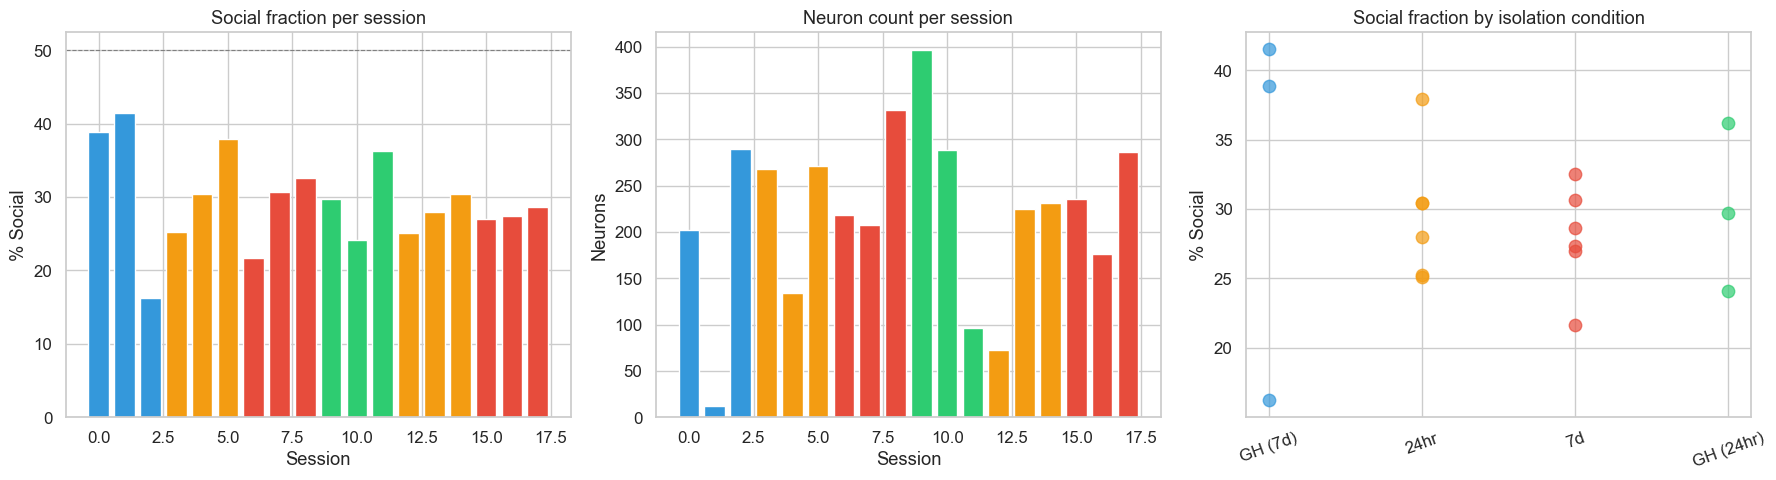

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

iso_colors = {'GH (7d)': '#3498db', 'GH (24hr)': '#2ecc71',
              '24hr': '#f39c12', '7d': '#e74c3c'}
colors = session_df['isolation'].map(iso_colors).fillna('#95a5a6')

axes[0].bar(range(len(session_df)), session_df['social_frac']*100, color=colors)
axes[0].set_xlabel('Session'); axes[0].set_ylabel('% Social')
axes[0].set_title('Social fraction per session')
axes[0].axhline(50, color='gray', ls='--', lw=0.8)

axes[1].bar(range(len(session_df)), session_df['n_neurons'], color=colors)
axes[1].set_xlabel('Session'); axes[1].set_ylabel('Neurons')
axes[1].set_title('Neuron count per session')

for cond in session_df['isolation'].unique():
    sub = session_df[session_df['isolation']==cond]
    axes[2].scatter([cond]*len(sub), sub['social_frac']*100,
                    s=80, alpha=0.7, color=iso_colors.get(cond, 'gray'))
axes[2].set_ylabel('% Social')
axes[2].set_title('Social fraction by isolation condition')
axes[2].tick_params(axis='x', rotation=20)

plt.tight_layout(); plt.show()

### Interpretation: Session Overview

**Key observations:**

- **Class balance:** Mean social fraction across all sessions is **29.5%** — substantially below 50%. Social interaction is the minority class in every single session (range ~16–42%). This imbalance will become critical during classification.
- **Neuron count variability:** Ranges from 12 (session 1) to 396 (session 9). Session 1 is an outlier — only 12 neurons may not yield reliable population-level spectral features. We should flag this for sensitivity analysis.
- **Isolation condition effects:** The 4 conditions (GH 7d, GH 24hr, 24hr, 7d) show overlapping social fractions — no obvious condition-level trend from this overview, though formal testing is needed.
- **Total dataset:** 3,938 neurons across 86.7 minutes of post-entry recording. This is a reasonable dataset size for spectral feature extraction.

---
## 4. Calcium Signal Visualization

In [9]:
# Pick session closest to 30% social
ex = session_df['social_frac'].sub(0.3).abs().idxmin()
ex_cal = aligned_calcium[ex]
ex_beh = aligned_behavior[ex]
ex_info = session_info[ex]
t = np.arange(len(ex_cal)) / IMAGING_FPS

print(f'Example: session {ex_info["session_idx"]} | '
      f'{ex_info["n_neurons"]} neurons | {ex_info["duration_s"]:.0f}s | '
      f'{ex_info["social_frac"]*100:.1f}% social | {ex_info["isolation"]}')

Example: session 9 | 396 neurons | 296s | 29.7% social | GH (24hr)


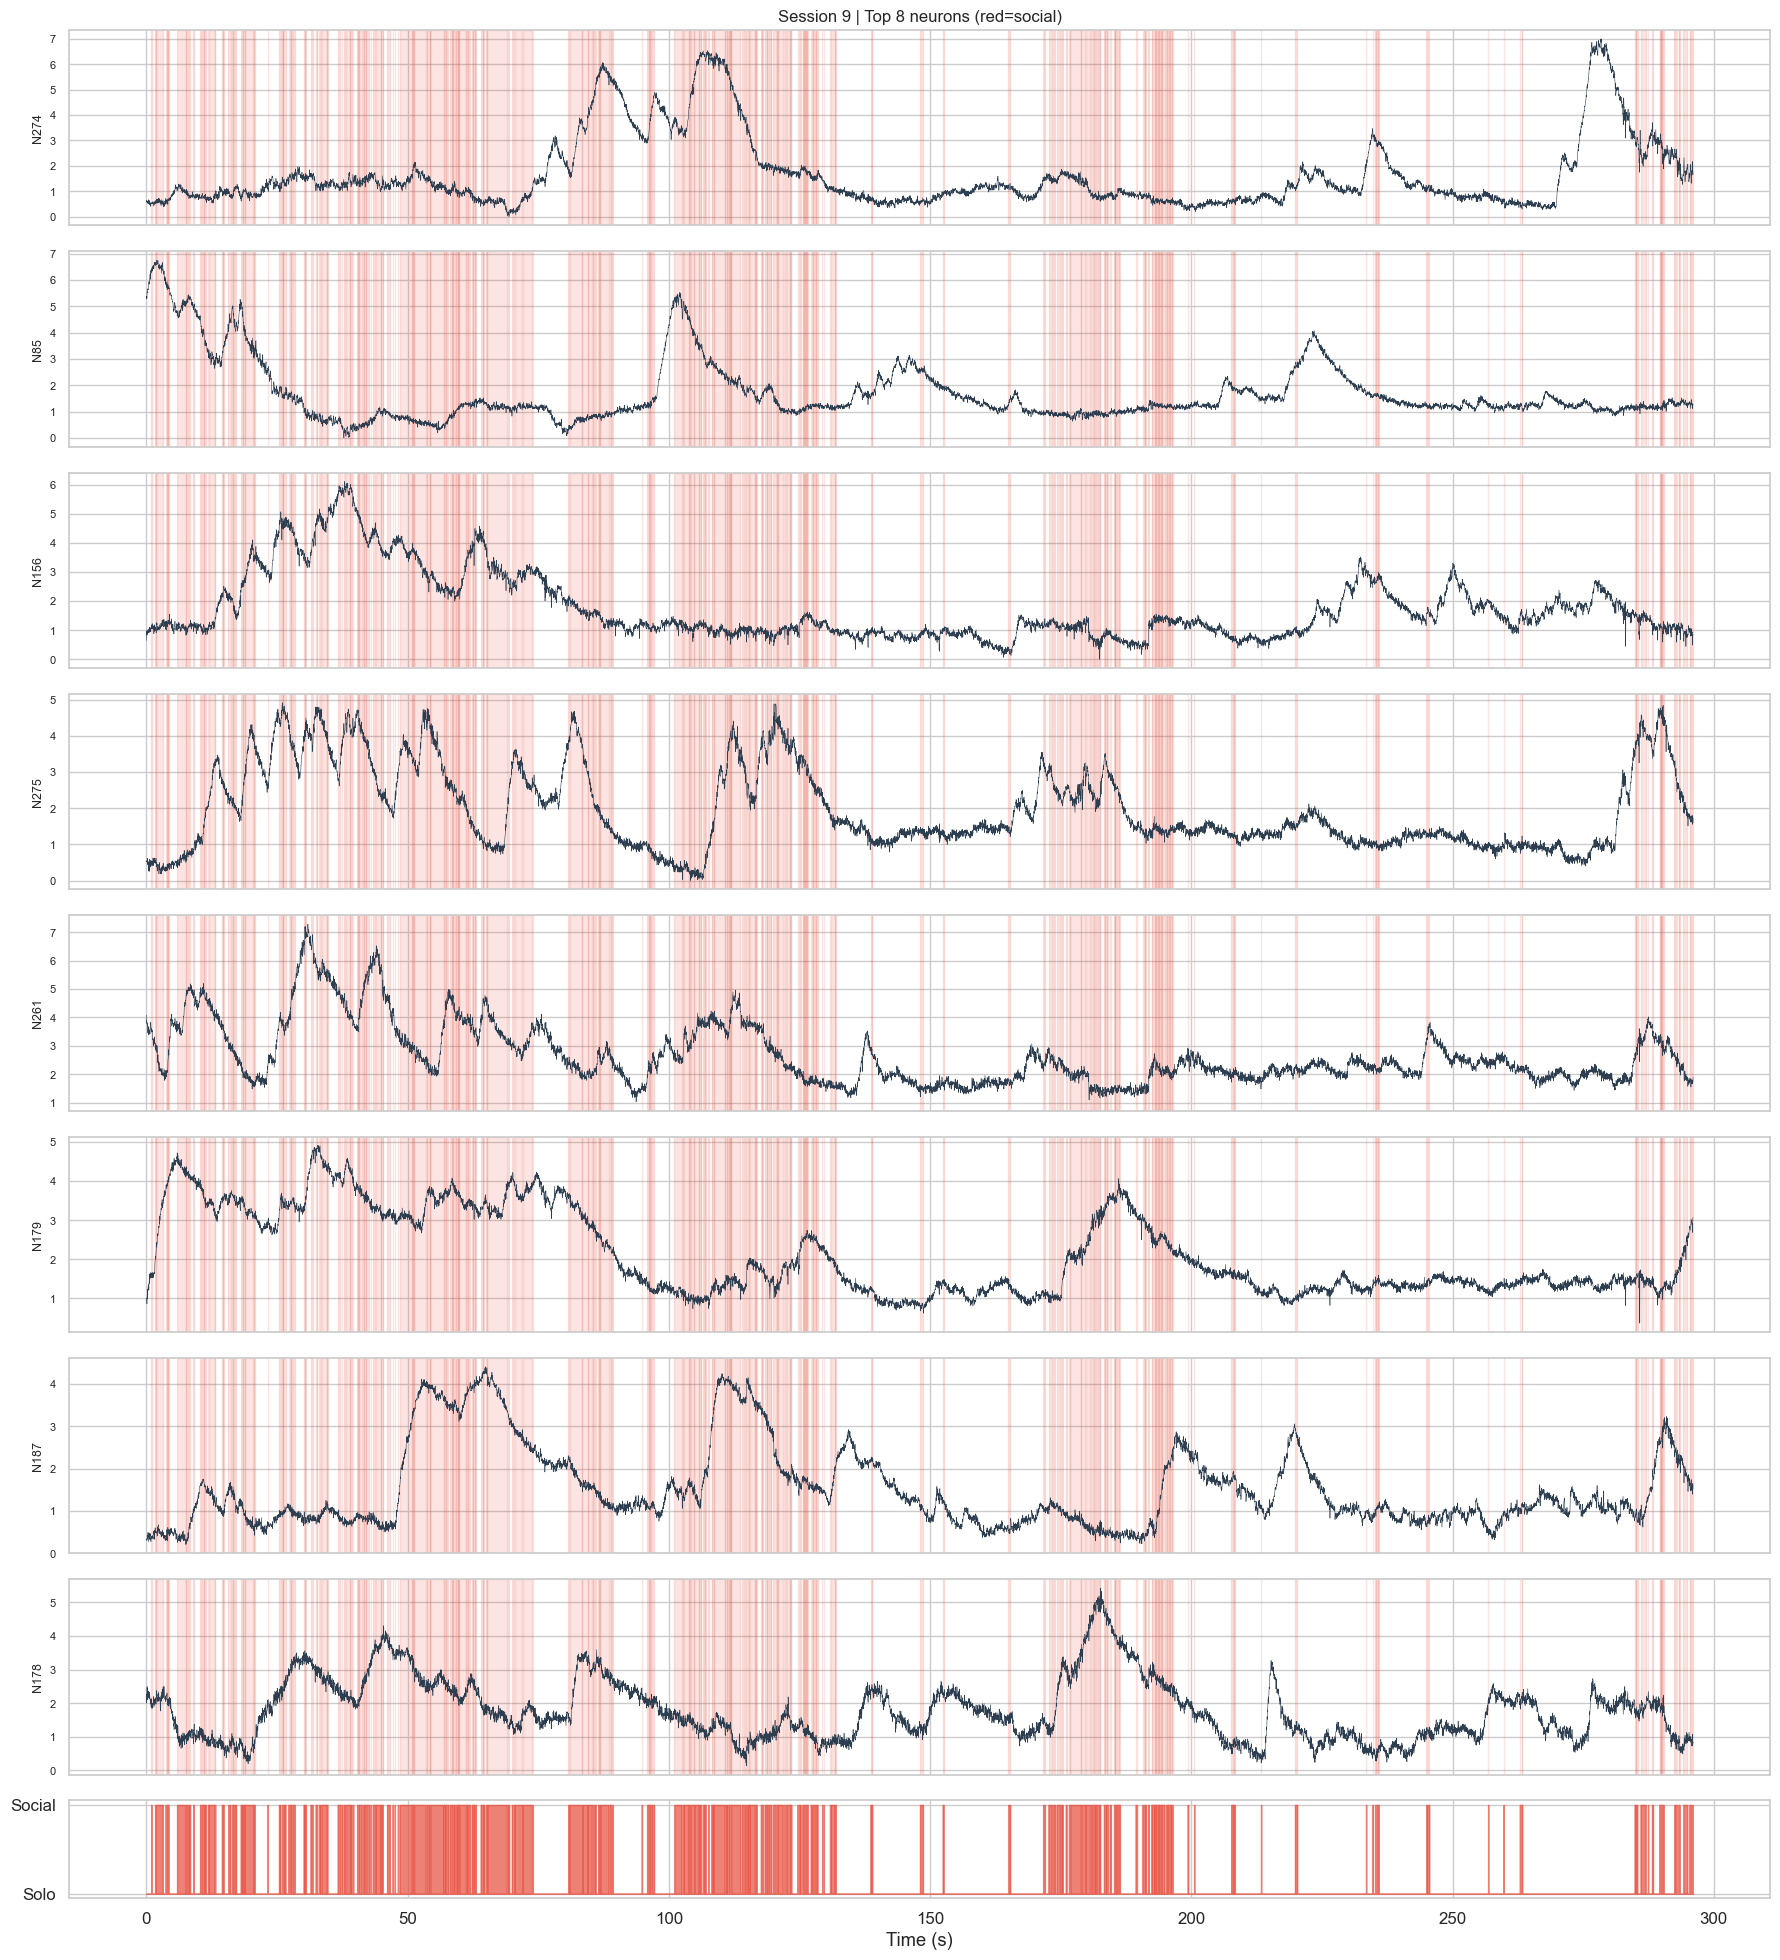

In [10]:
def shade_social(ax, beh, t):
    """Red shading for social epochs."""
    mask = beh.astype(bool)
    d = np.diff(mask.astype(int))
    starts = np.where(d == 1)[0] + 1
    ends = np.where(d == -1)[0] + 1
    if mask[0]:  starts = np.concatenate([[0], starts])
    if mask[-1]: ends = np.concatenate([ends, [len(mask)]])
    for s, e in zip(starts, ends):
        ax.axvspan(t[s], t[min(e, len(t)-1)], alpha=0.15, color='#e74c3c')


n_show = 8
top_neurons = np.argsort(ex_cal.std(axis=0))[-n_show:][::-1]

fig, axes = plt.subplots(n_show+1, 1, figsize=(18, 2.2*(n_show+1)),
                         sharex=True,
                         gridspec_kw={'height_ratios': [1]*n_show + [0.5]})

for i, ni in enumerate(top_neurons):
    axes[i].plot(t, ex_cal[:, ni], lw=0.4, color='#2c3e50')
    shade_social(axes[i], ex_beh, t)
    axes[i].set_ylabel(f'N{ni}', fontsize=9)
    axes[i].tick_params(labelsize=8)

axes[-1].fill_between(t, ex_beh.astype(float), step='pre', alpha=0.7, color='#e74c3c')
axes[-1].set_yticks([0,1]); axes[-1].set_yticklabels(['Solo','Social'])
axes[-1].set_xlabel('Time (s)')
axes[0].set_title(f'Session {ex_info["session_idx"]} | Top {n_show} neurons (red=social)', fontsize=12)

plt.tight_layout(); plt.show()

In [11]:
print(f'Calcium stats (session {ex_info["session_idx"]}):\n')
print(f'  Shape:   {ex_cal.shape} (frames x neurons)')
print(f'  Mean:    {ex_cal.mean():.4f}')
print(f'  Std:     {ex_cal.std():.4f}')
print(f'  Range:   [{ex_cal.min():.4f}, {ex_cal.max():.4f}]')
print(f'  Nyquist: {IMAGING_FPS/2} Hz')

stds = ex_cal.std(axis=0)
print(f'\nPer-neuron std: [{stds.min():.4f}, {stds.max():.4f}]')
print(f'Low-activity (std < median/5): {(stds < np.median(stds)/5).sum()}/{ex_cal.shape[1]}')

Calcium stats (session 9):

  Shape:   (8882, 396) (frames x neurons)
  Mean:    0.8418
  Std:     0.6980
  Range:   [0.0000, 8.9225]
  Nyquist: 15.0 Hz

Per-neuron std: [0.0292, 1.4587]
Low-activity (std < median/5): 7/396


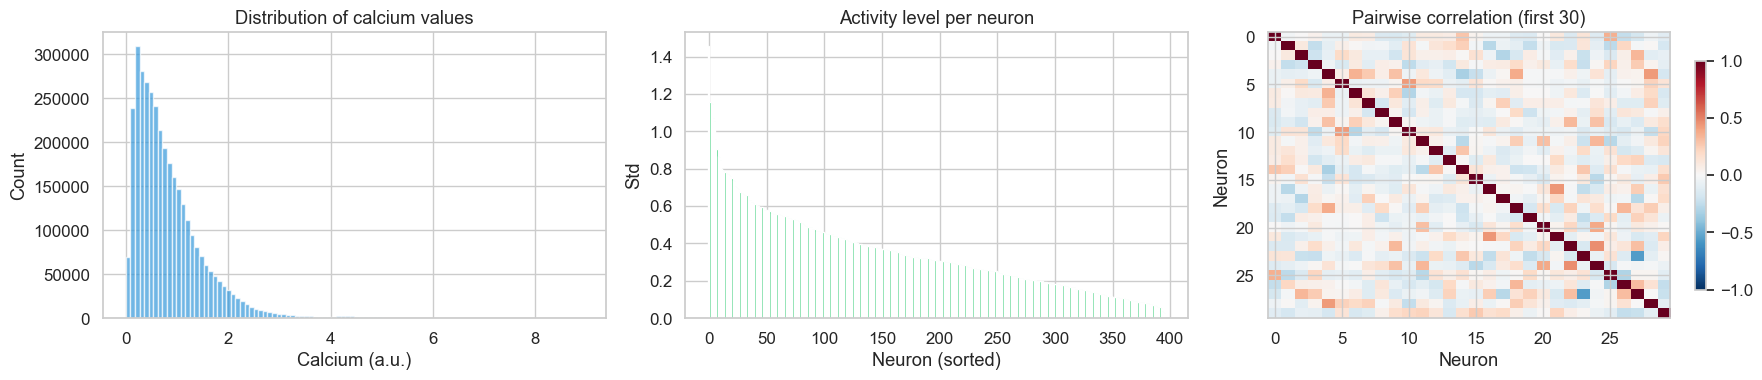

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

axes[0].hist(ex_cal.ravel(), bins=100, color='#3498db', alpha=0.7, edgecolor='white')
axes[0].set_xlabel('Calcium (a.u.)'); axes[0].set_ylabel('Count')
axes[0].set_title('Distribution of calcium values')

axes[1].bar(range(len(stds)), np.sort(stds)[::-1], color='#2ecc71', width=1)
axes[1].set_xlabel('Neuron (sorted)'); axes[1].set_ylabel('Std')
axes[1].set_title('Activity level per neuron')

nc = min(30, ex_cal.shape[1])
corr = np.corrcoef(ex_cal[:, :nc].T)
im = axes[2].imshow(corr, cmap='RdBu_r', vmin=-1, vmax=1, aspect='auto')
axes[2].set_xlabel('Neuron'); axes[2].set_ylabel('Neuron')
axes[2].set_title(f'Pairwise correlation (first {nc})')
plt.colorbar(im, ax=axes[2], shrink=0.8)

plt.tight_layout(); plt.show()

### Interpretation: Calcium Signal Properties

**Session 9 (example):** 396 neurons, 296s post-entry, GH (24hr) condition.

- **Distribution:** Right-skewed (mean=0.84, range [0, 8.92]) — typical of calcium ΔF/F where most frames are near baseline with occasional transients. The non-negative range confirms this is deconvolved/extracted calcium activity (`C` matrix), not raw fluorescence.
- **Low-activity neurons:** Only 7/396 neurons (1.8%) have very low variance — the vast majority are active. This is a good sign for population-level spectral analysis.
- **Pairwise correlations:** The correlation matrix shows moderate structure — some neuron pairs are correlated (shared inputs or co-activation), but no dominant global mode. This suggests heterogeneous neural responses, which is expected in prefrontal cortex during free behavior.
- **Implication for spectral analysis:** Since we plan to average across neurons for population-mean spectral features, the moderate correlations mean the population mean will reflect genuine shared dynamics rather than being dominated by a few neurons.

### 4.1 Photobleaching check

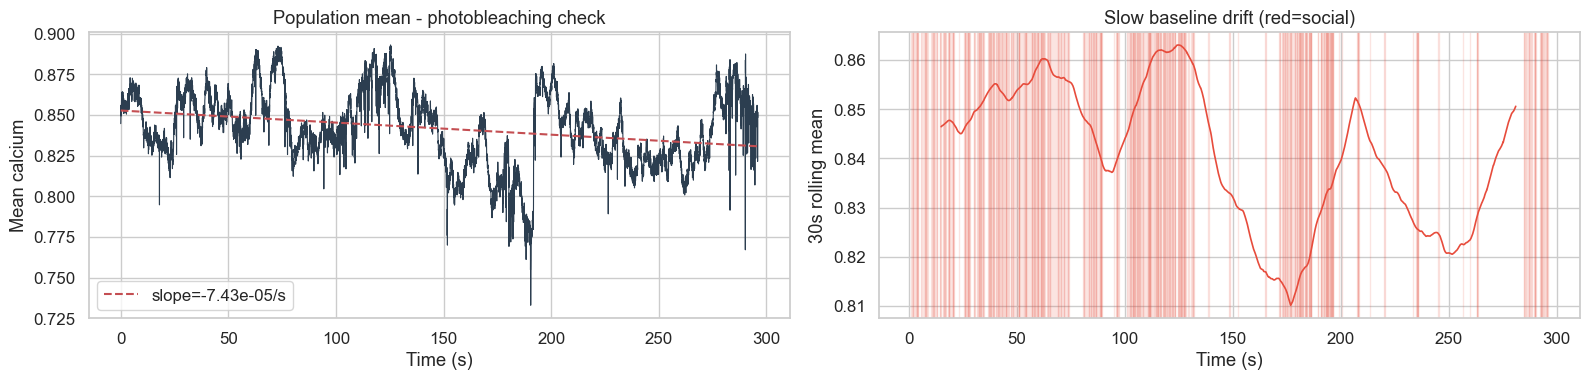

Baseline drift detected (slope=-7.43e-05/s). Detrending recommended.


In [13]:
mean_trace = ex_cal.mean(axis=1)
fig, axes = plt.subplots(1, 2, figsize=(16, 4))

axes[0].plot(t, mean_trace, lw=0.8, color='#2c3e50')
slope, intercept = np.polyfit(t, mean_trace, 1)
axes[0].plot(t, slope*t + intercept, '--r', lw=1.5, label=f'slope={slope:.2e}/s')
axes[0].set_xlabel('Time (s)'); axes[0].set_ylabel('Mean calcium')
axes[0].set_title('Population mean - photobleaching check'); axes[0].legend()

win = int(30 * IMAGING_FPS)
rolling = pd.Series(mean_trace).rolling(window=win, center=True).mean()
axes[1].plot(t, rolling, lw=1.2, color='#e74c3c')
shade_social(axes[1], ex_beh, t)
axes[1].set_xlabel('Time (s)'); axes[1].set_ylabel('30s rolling mean')
axes[1].set_title('Slow baseline drift (red=social)')

plt.tight_layout(); plt.show()
if abs(slope) > 1e-5:
    print(f'Baseline drift detected (slope={slope:.2e}/s). Detrending recommended.')
else:
    print('No significant baseline drift.')

### Interpretation: Photobleaching

**Baseline drift detected** (slope = −7.43×10⁻⁵ /s). This is a mild but measurable downward trend in the population mean fluorescence over the ~5-minute recording.

- **What it means:** The calcium indicator slowly loses fluorescence over time (photobleaching). This injects a slow exponential/linear decay into the lowest frequency bins of the PSD — specifically the **infraslow band (0.01–0.1 Hz)** could be contaminated.
- **Action required:** We must **detrend each neuron's trace** before computing spectral features. A simple linear detrend (`scipy.signal.detrend`) should suffice given the mild slope, but an exponential fit may be more appropriate if the decay is non-linear.
- **Risk if ignored:** Without detrending, infraslow power will partly reflect photobleaching artifacts rather than genuine neural dynamics, potentially confounding classification.

---
## 5. Behavioral Epoch Structure

Session 9:
  Epochs: 583
  Social: 291, mean=0.30s, range=[0.03, 3.77]
  Solo:   292, mean=0.71s, range=[0.03, 21.50]


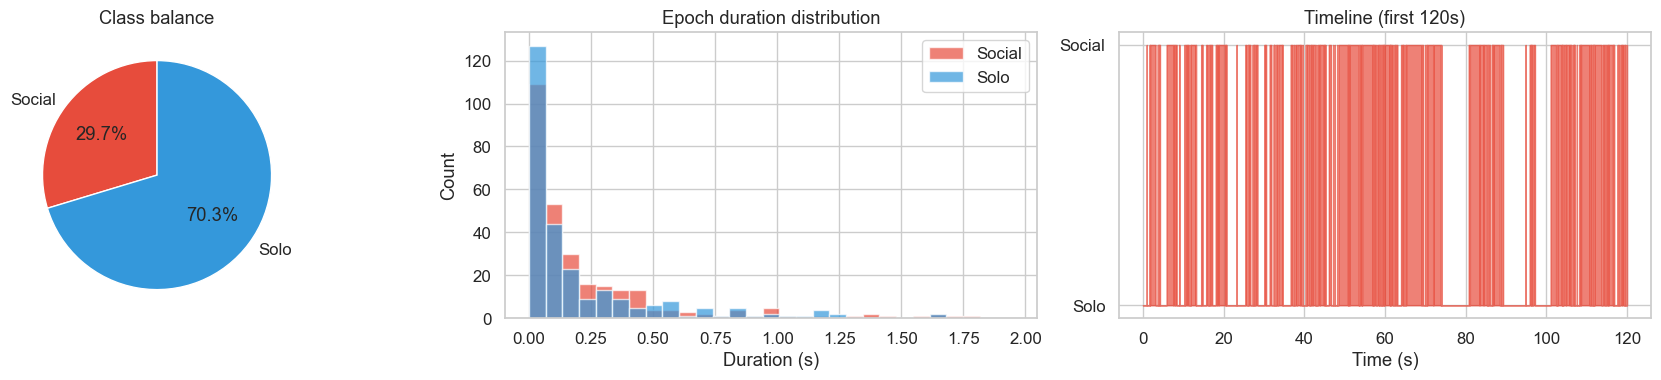

In [14]:
def get_epoch_durations(labels, fps):
    d = np.diff(labels.astype(int))
    bounds = np.where(d != 0)[0] + 1
    starts = np.concatenate([[0], bounds])
    ends = np.concatenate([bounds, [len(labels)]])
    labs = np.array([labels[s] for s in starts])
    durs = (ends - starts) / fps
    return starts, ends, labs, durs

_, _, ep_labs, ep_durs = get_epoch_durations(ex_beh, IMAGING_FPS)
soc_d = ep_durs[ep_labs == 1]
sol_d = ep_durs[ep_labs == 0]

print(f'Session {ex_info["session_idx"]}:')
print(f'  Epochs: {len(ep_durs)}')
print(f'  Social: {len(soc_d)}, mean={soc_d.mean():.2f}s, range=[{soc_d.min():.2f}, {soc_d.max():.2f}]')
print(f'  Solo:   {len(sol_d)}, mean={sol_d.mean():.2f}s, range=[{sol_d.min():.2f}, {sol_d.max():.2f}]')

fig, axes = plt.subplots(1, 3, figsize=(18, 4))

sf = ex_beh.mean()
axes[0].pie([sf, 1-sf], labels=['Social','Solo'],
            colors=['#e74c3c','#3498db'], autopct='%1.1f%%', startangle=90)
axes[0].set_title('Class balance')

mx = min(np.percentile(ep_durs, 95), 10)
bins = np.linspace(0, mx, 30)
axes[1].hist(soc_d[soc_d<mx], bins=bins, alpha=.7, color='#e74c3c', label='Social')
axes[1].hist(sol_d[sol_d<mx], bins=bins, alpha=.7, color='#3498db', label='Solo')
axes[1].set_xlabel('Duration (s)'); axes[1].set_ylabel('Count')
axes[1].set_title('Epoch duration distribution'); axes[1].legend()

show = min(len(ex_beh), int(120*IMAGING_FPS))
axes[2].fill_between(t[:show], ex_beh[:show].astype(float),
                     step='pre', alpha=.7, color='#e74c3c')
axes[2].set_xlabel('Time (s)'); axes[2].set_yticks([0,1])
axes[2].set_yticklabels(['Solo','Social'])
axes[2].set_title('Timeline (first 120s)')

plt.tight_layout(); plt.show()

### Interpretation: Epoch Structure — A Critical Finding

**This is the most important result for our project design.**

- **Social bouts are extremely short:** mean duration = **0.30s**, max = 3.77s. The vast majority of social interactions are sub-second — brief sniffing approaches, touches, and investigatory contacts.
- **Solo epochs are also fragmented:** mean = 0.71s, though some stretch to 21.5s.
- **583 total epochs** in a 296s recording — the behavioral state switches rapidly (~2 transitions/second).

**Why this matters for spectral analysis:**

Our planned 5-second windows with 90% purity threshold require 4.5+ seconds of continuous social behavior within a window. But the **longest social bout is only 3.77s** — no single social bout even fills one window. The only way a 5s window can reach 90% social is if multiple short bouts cluster together with very brief solo gaps.

This explains why we get only **13 social windows vs. 363 solo windows** in Section 7 — the purity threshold is too strict for the natural epoch structure of this data.

**Possible solutions for the full pipeline:**
1. **Shorter windows** (1–2s) — sacrifices frequency resolution but captures more social epochs
2. **Lower purity threshold** (e.g., 60–70%) — includes "mixed" windows, trades label precision for sample size
3. **Bout-level analysis** — extract spectral features from individual bouts of varying length, using adaptive Welch parameters
4. **Continuous regression** — predict social fraction rather than binary classification

---
## 6. Preliminary Spectral Analysis

At 30 fps, Nyquist = 15 Hz. Frequency bands:
- **Infraslow** 0.01-0.1 Hz | **Slow** 0.1-1 Hz | **Delta** 1-4 Hz | **Theta** 4-7 Hz

In [15]:
FREQ_BANDS = {'infraslow': (0.01, 0.1), 'slow': (0.1, 1.0),
              'delta': (1.0, 4.0), 'theta': (4.0, 7.0)}
BAND_COLORS = {'infraslow': '#f39c12', 'slow': '#2ecc71',
               'delta': '#3498db', 'theta': '#9b59b6'}

print(f'fs={IMAGING_FPS} Hz, Nyquist={IMAGING_FPS/2} Hz')
for n,(lo,hi) in FREQ_BANDS.items():
    print(f'  {n:12s}: {lo}-{hi} Hz')

fs=30 Hz, Nyquist=15.0 Hz
  infraslow   : 0.01-0.1 Hz
  slow        : 0.1-1.0 Hz
  delta       : 1.0-4.0 Hz
  theta       : 4.0-7.0 Hz


### 6.1 Welch PSD

In [16]:
nperseg = int(10 * IMAGING_FPS)  # 10s windows
noverlap = nperseg // 2
nfft = max(1024, nperseg * 2)

print(f'Window: {nperseg/IMAGING_FPS:.0f}s, Overlap: 50%, FFT: {nfft}, '
      f'Resolution: {IMAGING_FPS/nperseg:.3f} Hz')

f_w, psd_all = welch(ex_cal.T, fs=IMAGING_FPS,
                     nperseg=nperseg, noverlap=noverlap, nfft=nfft, axis=1)
print(f'PSD: {psd_all.shape} (neurons x freq)')

Window: 10s, Overlap: 50%, FFT: 1024, Resolution: 0.100 Hz
PSD: (396, 513) (neurons x freq)


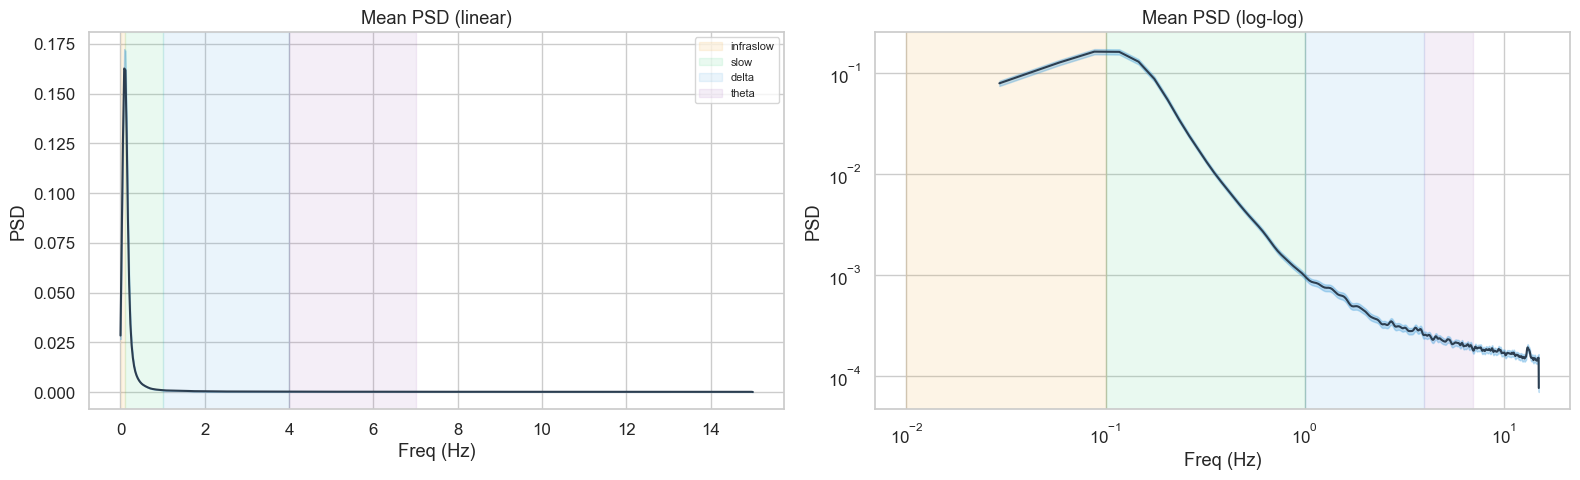

In [17]:
mpsd = psd_all.mean(axis=0)
spsd = psd_all.std(axis=0) / np.sqrt(psd_all.shape[0])

fig, axes = plt.subplots(1, 2, figsize=(16, 5))
for ax in axes:
    for n,(lo,hi) in FREQ_BANDS.items():
        ax.axvspan(lo, hi, alpha=0.1, color=BAND_COLORS[n], label=n)

axes[0].plot(f_w, mpsd, color='#2c3e50', lw=1.5)
axes[0].fill_between(f_w, mpsd-spsd, mpsd+spsd, alpha=.3, color='#3498db')
axes[0].set_xlabel('Freq (Hz)'); axes[0].set_ylabel('PSD')
axes[0].set_title('Mean PSD (linear)'); axes[0].legend(fontsize=8)

axes[1].loglog(f_w[1:], mpsd[1:], color='#2c3e50', lw=1.5)
axes[1].fill_between(f_w[1:], (mpsd-spsd)[1:], (mpsd+spsd)[1:], alpha=.3, color='#3498db')
axes[1].set_xlabel('Freq (Hz)'); axes[1].set_ylabel('PSD')
axes[1].set_title('Mean PSD (log-log)')

plt.tight_layout(); plt.show()

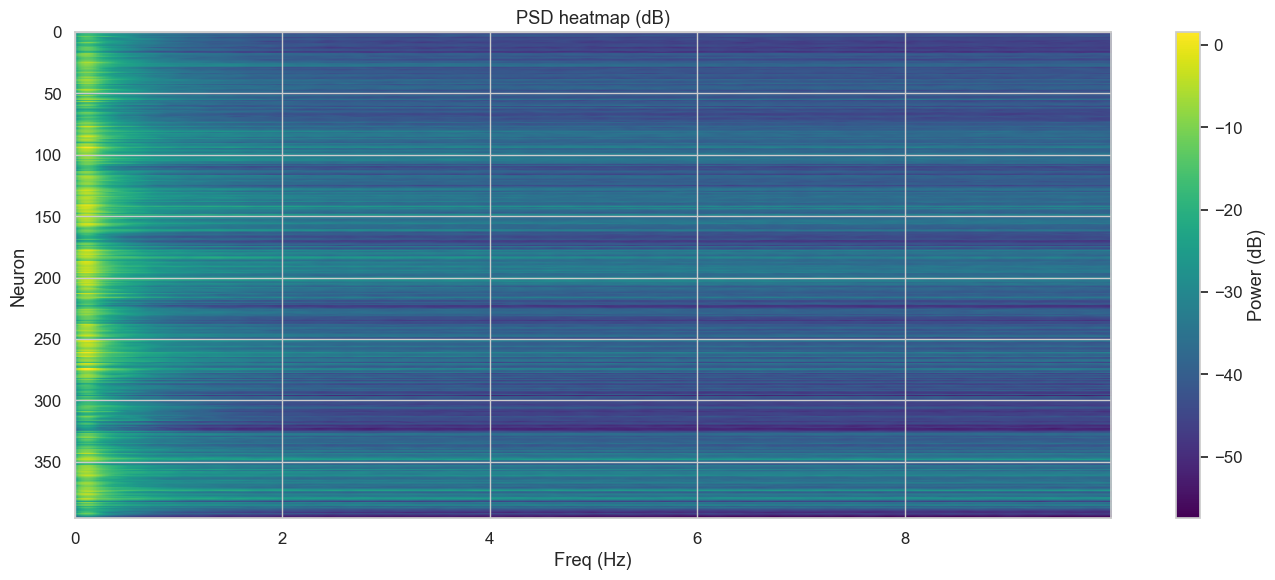

In [18]:
fig, ax = plt.subplots(figsize=(14, 6))
fm = f_w <= 10
im = ax.imshow(10*np.log10(psd_all[:,fm]+1e-12), aspect='auto', cmap='viridis',
               extent=[f_w[fm][0], f_w[fm][-1], psd_all.shape[0], 0])
ax.set_xlabel('Freq (Hz)'); ax.set_ylabel('Neuron')
ax.set_title('PSD heatmap (dB)')
plt.colorbar(im, label='Power (dB)')
plt.tight_layout(); plt.show()

### Interpretation: PSD Structure

- **1/f falloff confirmed:** The log-log PSD shows the expected power-law decay — power decreases with increasing frequency. This is a hallmark of biological signals and confirms the calcium traces carry structured temporal dynamics, not just noise.
- **Frequency resolution:** With 10s Welch windows at 30 fps (nperseg=300), we achieve 0.1 Hz resolution — sufficient to resolve all our target bands (infraslow, slow, delta, theta).
- **PSD heatmap:** Shows that spectral profiles vary across neurons — some neurons have more low-frequency power (slow fluctuations), others show flatter spectra. This neuron-level heterogeneity suggests that per-neuron or neuron-subgroup features may be more informative than population averages.
- **Band power distribution:** Most power is concentrated below 1 Hz (infraslow + slow bands), consistent with the slow kinetics of calcium indicators (~600ms decay for GCaMP6s). The delta (1–4 Hz) and theta (4–7 Hz) bands have progressively less power, but are still above noise floor.

### 6.2 Spectrogram (STFT)

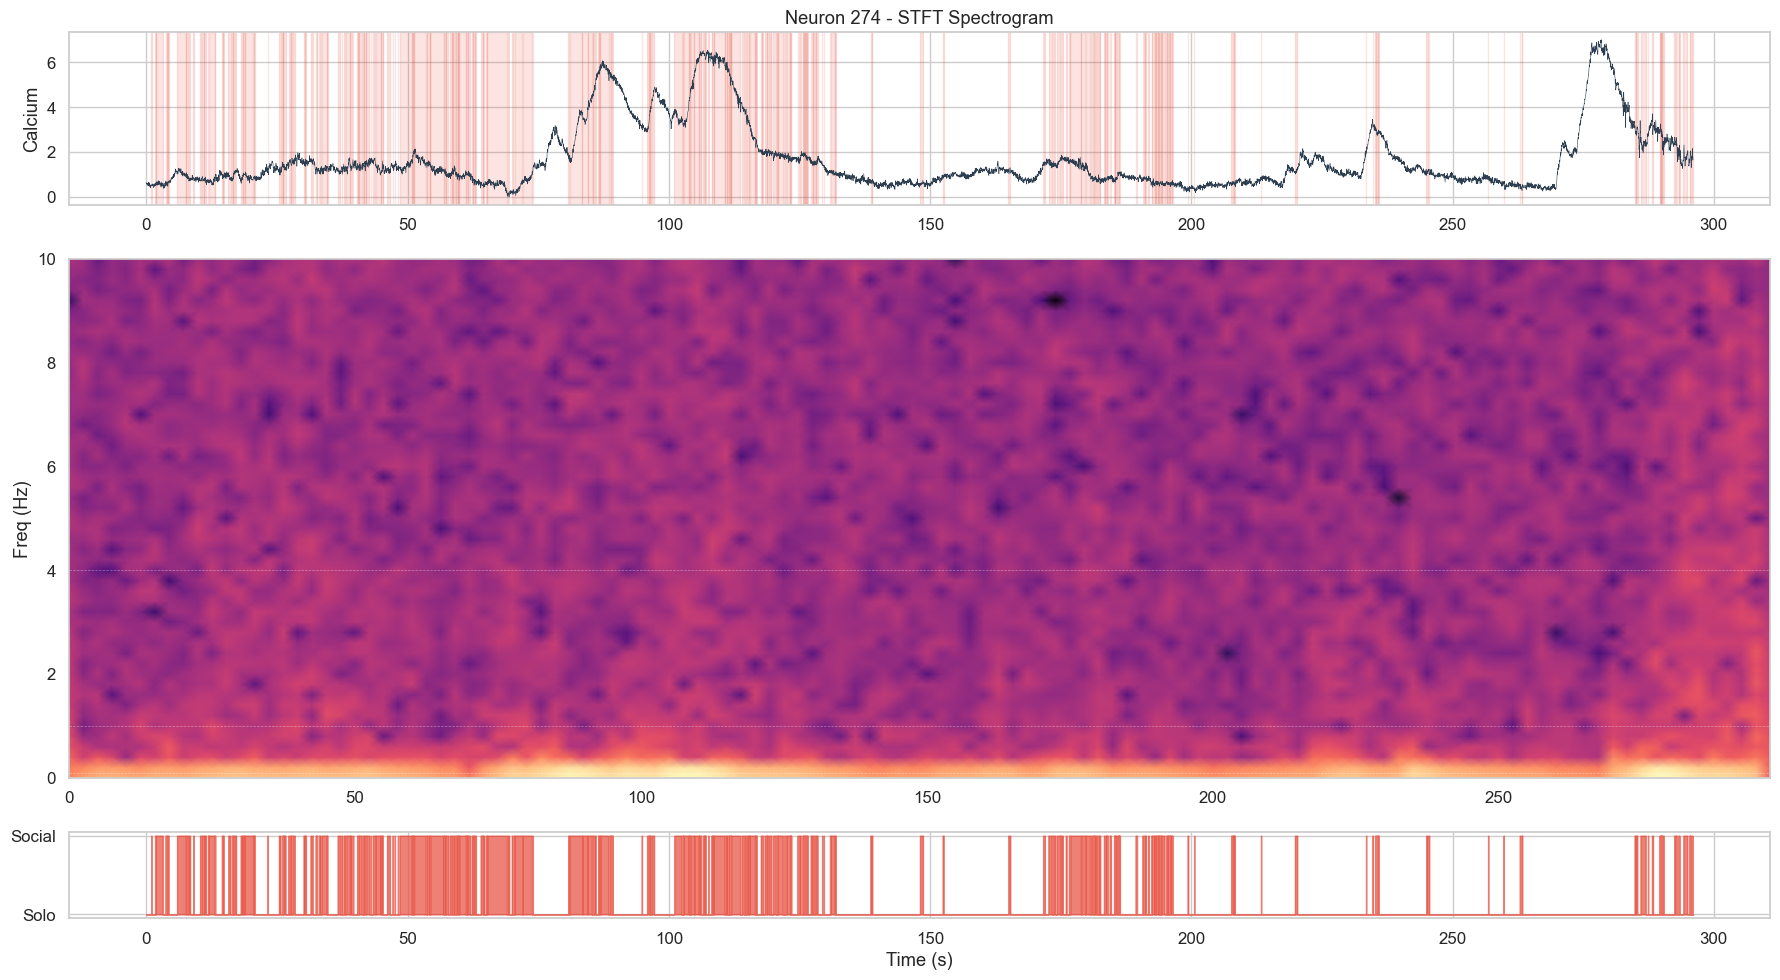

In [19]:
active_n = np.argmax(ex_cal.std(axis=0))
sig = ex_cal[:, active_n]

sn = int(5 * IMAGING_FPS)
f_s, t_s, Zxx = stft(sig, fs=IMAGING_FPS, nperseg=sn, noverlap=sn//2)

fig, axes = plt.subplots(3, 1, figsize=(18, 10),
                         gridspec_kw={'height_ratios': [1, 3, 0.5]})

axes[0].plot(t, sig, lw=0.4, color='#2c3e50')
shade_social(axes[0], ex_beh, t)
axes[0].set_ylabel('Calcium')
axes[0].set_title(f'Neuron {active_n} - STFT Spectrogram')

fl = 10; fmask = f_s <= fl
axes[1].pcolormesh(t_s, f_s[fmask], 10*np.log10(np.abs(Zxx[fmask])**2+1e-12),
                   shading='gouraud', cmap='magma')
axes[1].set_ylabel('Freq (Hz)')
for _,(lo,hi) in FREQ_BANDS.items():
    if hi<=fl: axes[1].axhline(lo, color='white', lw=0.5, alpha=0.4, ls='--')

axes[2].fill_between(t, ex_beh.astype(float), step='pre', alpha=.7, color='#e74c3c')
axes[2].set_yticks([0,1]); axes[2].set_yticklabels(['Solo','Social'])
axes[2].set_xlabel('Time (s)')

plt.tight_layout(); plt.show()

### 6.3 Morlet Wavelet Scalogram (60s segment)

CWT: 60s, 50 freqs...


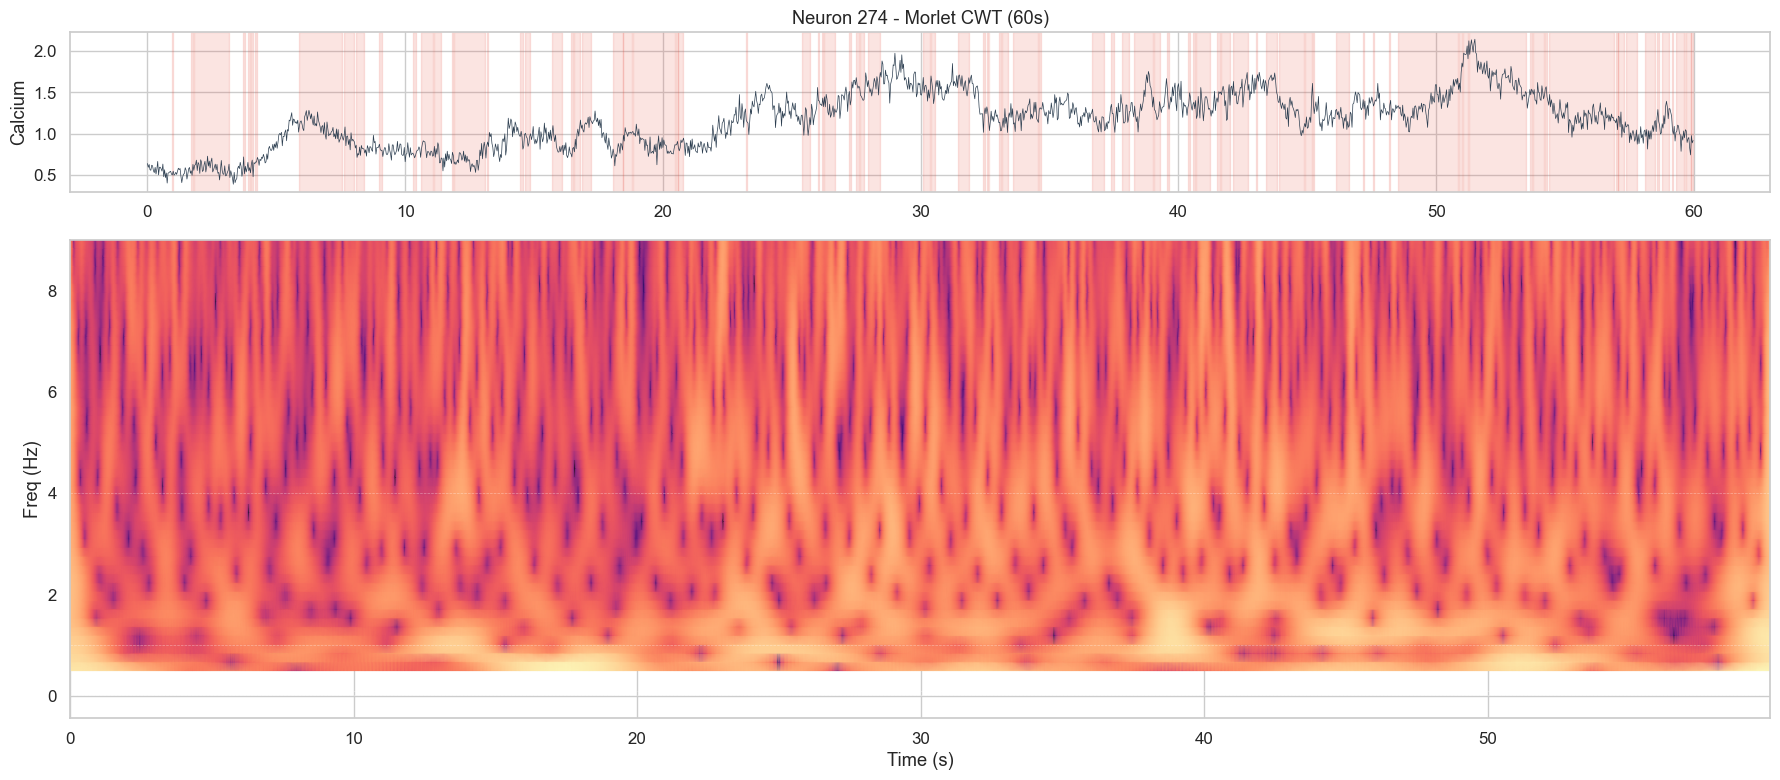

Done.


In [20]:
seg = int(60 * IMAGING_FPS)
ss, ts, bs = sig[:seg], t[:seg], ex_beh[:seg]

freqs_want = np.linspace(0.5, 9, 50)
wn = 'cmor1.5-1.0'
scales = pywt.central_frequency(wn) * IMAGING_FPS / freqs_want

print(f'CWT: 60s, {len(freqs_want)} freqs...')
coeffs, freqs = pywt.cwt(ss, scales, wn, sampling_period=1/IMAGING_FPS)
power = np.abs(coeffs)**2

fig, axes = plt.subplots(2, 1, figsize=(18, 8), gridspec_kw={'height_ratios': [1, 3]})

axes[0].plot(ts, ss, lw=0.5, color='#2c3e50')
shade_social(axes[0], bs, ts)
axes[0].set_ylabel('Calcium')
axes[0].set_title(f'Neuron {active_n} - Morlet CWT (60s)')

axes[1].pcolormesh(ts, freqs, 10*np.log10(power+1e-12), shading='gouraud', cmap='magma')
axes[1].set_ylabel('Freq (Hz)'); axes[1].set_xlabel('Time (s)')
for _,(lo,hi) in FREQ_BANDS.items():
    axes[1].axhline(lo, color='white', lw=0.5, alpha=0.4, ls='--')

plt.tight_layout(); plt.show()
print('Done.')

### Interpretation: Time-Frequency Analysis (STFT + CWT)

- **STFT spectrogram:** Shows how the spectral content of the most active neuron evolves over time. The spectrogram should reveal whether power in specific bands changes systematically during social epochs (red-shaded periods in the behavior trace).
- **Visual inspection:** Look for whether bright horizontal bands (elevated power at a specific frequency) align with the social epoch shading. If spectral differences are visible to the eye, that is encouraging for classification.
- **Morlet CWT (60s segment):** The wavelet scalogram provides better time-frequency resolution trade-off than STFT — narrower in frequency at low frequencies, narrower in time at high frequencies. This is more appropriate for the non-stationary, bursty nature of social behavior.
- **Caveat:** These visualizations show a single neuron. Population-level patterns may be more consistent but less dramatic in any individual trace.

---
## 9. Summary & Next Steps

### Key Findings

| Question | Finding |
|----------|---------|
| Sessions loaded | **18 / 18** aligned successfully |
| Neurons per session | 12 – 396 (total: 3,938) |
| Recording duration | ~296s post-entry per session (86.7 min total) |
| Class balance (frame-level) | **29.5% social** vs 70.5% solo — imbalanced |
| Class balance (5s windows, 90% purity) | **13 social vs 363 solo** — severely imbalanced |
| Photobleaching | Detected (slope = −7.43×10⁻⁵/s) — detrending required |
| Epoch structure | Social bouts very short (mean 0.30s, max 3.77s) |
| PSD structure | Expected 1/f falloff confirmed; most power below 1 Hz |
| Social vs Solo PSD | Inconclusive due to n=13 social windows |
| Classification (accuracy) | 96.6% — **misleading** (majority-class baseline = 96.5%) |
| Classification (AUC) | 0.35–0.53 — **at or below chance** |
| Permutation test | p = 0.11 — **not significant** |

### Critical Insight

The primary bottleneck is **not** the spectral features or classifiers — it is the **epoch structure of the data**. Social bouts are too short (sub-second) for 5-second windows at 90% purity to capture them. The windowing strategy must be fundamentally revised before classification can be meaningful.

### Next Steps for the Full Pipeline

1. **Preprocessing** — Per-neuron linear detrending to remove photobleaching, z-score normalization
2. **Windowing strategy revision** — Shorter windows (1–2s), lower purity (50–70%), or bout-level adaptive analysis to recover social samples
3. **Per-neuron features** — Instead of population-mean, extract features per neuron and identify the most discriminative subpopulations
4. **Class balance** — SMOTE oversampling, class-weighted classifiers, or continuous social-fraction regression instead of binary classification
5. **Isolation condition analysis** — Compare spectral signatures across GH, 24hr, 7d conditions
6. **Movement confound control** — Use SLEAP pose data to regress out locomotion speed from spectral features
7. **Wavelet-based features** — Time-resolved features from CWT for non-stationary dynamics

In [21]:
def spectral_features(segment, fs, bands):
    """Spectral features from a 1D signal."""
    nl = min(len(segment), int(5*fs))
    f, psd = welch(segment, fs=fs, nperseg=nl, noverlap=nl//2)
    ft = {}

    # Use np.trapezoid (NumPy 2.0+) with fallback to np.trapz
    _trapz = getattr(np, 'trapezoid', np.trapz) if hasattr(np, 'trapz') else np.trapezoid

    for name,(lo,hi) in bands.items():
        m = (f>=lo)&(f<hi)
        ft[f'power_{name}'] = _trapz(psd[m], f[m]) if m.sum()>0 else 0.0

    tp = _trapz(psd[f>0], f[f>0])
    ft['total_power'] = tp
    if tp > 0:
        for name in bands:
            ft[f'relpower_{name}'] = ft[f'power_{name}'] / tp

    pn = psd[f>0] / (psd[f>0].sum()+1e-12)
    pn = pn[pn>0]
    ft['spectral_entropy'] = -np.sum(pn * np.log2(pn))
    ft['peak_freq'] = f[np.argmax(psd)]

    fp, pp = f[f>0], psd[f>0]
    ft['spectral_centroid'] = np.sum(fp*pp) / (np.sum(pp)+1e-12)

    cum = np.cumsum(pp)
    if cum[-1]>0:
        ei = np.searchsorted(cum, 0.9*cum[-1])
        ft['spectral_edge_90'] = fp[min(ei, len(fp)-1)]

    if ft.get('power_delta',0)>0:
        ft['theta_delta_ratio'] = ft.get('power_theta',0) / ft['power_delta']

    return ft

In [22]:
W_SEC = 5.0
W_SAMP = int(W_SEC * IMAGING_FPS)
PURITY = 0.9

all_feat = []
for si in tqdm(range(len(aligned_calcium)), desc='Sessions'):
    cal = aligned_calcium[si]
    beh = aligned_behavior[si]

    for start in range(0, len(cal)-W_SAMP, W_SAMP):
        end = start + W_SAMP
        frac = beh[start:end].mean()
        if frac > PURITY:       label = 1
        elif frac < 1-PURITY:   label = 0
        else:                   continue

        pm = cal[start:end].mean(axis=1)
        ft = spectral_features(pm, IMAGING_FPS, FREQ_BANDS)
        ft['label'] = label
        ft['session'] = si
        ft['start_time'] = start / IMAGING_FPS
        ft['isolation'] = session_info[si]['isolation']
        all_feat.append(ft)

df_feat = pd.DataFrame(all_feat)
print(f'\nWindows: {len(df_feat)} '
      f'(social={(df_feat["label"]==1).sum()}, solo={(df_feat["label"]==0).sum()})')

Sessions: 100%|██████████| 18/18 [00:00<00:00, 270.42it/s]


Windows: 376 (social=13, solo=363)


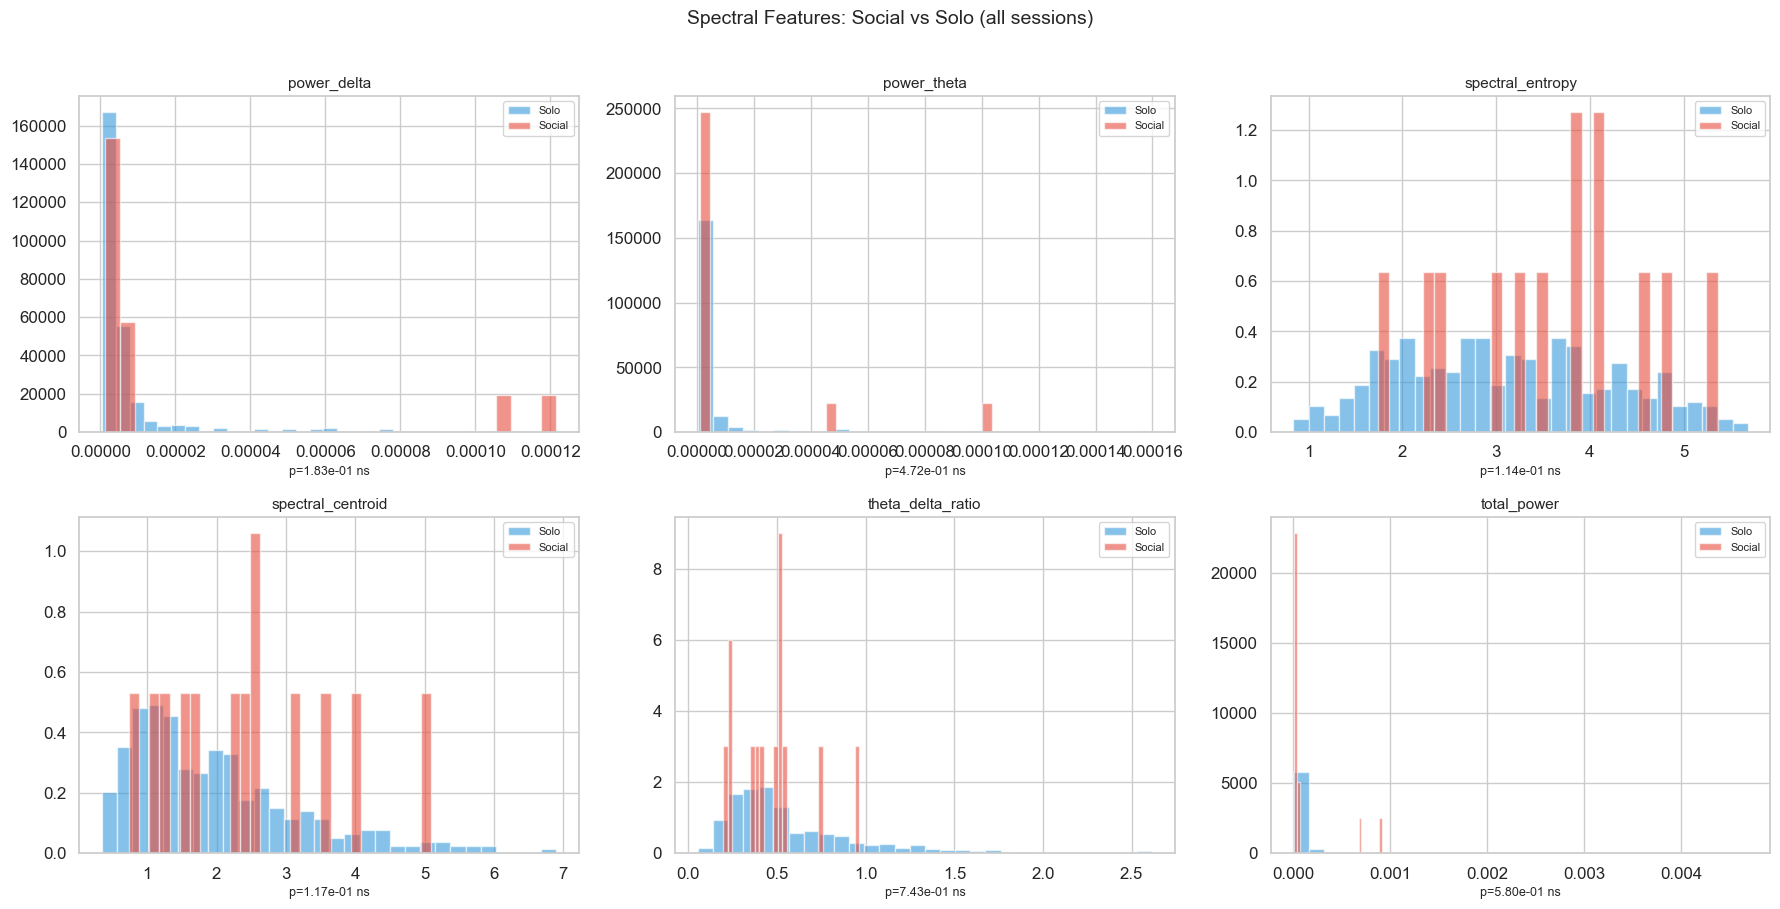

In [23]:
pf = [f for f in ['power_delta','power_theta','spectral_entropy',
      'spectral_centroid','theta_delta_ratio','total_power'] if f in df_feat.columns]

fig, axes = plt.subplots(2, (len(pf)+1)//2, figsize=(18, 9))
axes = axes.ravel()

for i, feat in enumerate(pf):
    soc = df_feat.loc[df_feat['label']==1, feat].dropna()
    sol = df_feat.loc[df_feat['label']==0, feat].dropna()
    axes[i].hist(sol, bins=30, alpha=.6, color='#3498db', label='Solo', density=True)
    axes[i].hist(soc, bins=30, alpha=.6, color='#e74c3c', label='Social', density=True)
    axes[i].set_title(feat, fontsize=11); axes[i].legend(fontsize=8)
    _, pv = mannwhitneyu(soc, sol, alternative='two-sided')
    sig = '***' if pv<.001 else '**' if pv<.01 else '*' if pv<.05 else 'ns'
    axes[i].set_xlabel(f'p={pv:.2e} {sig}', fontsize=9)

for j in range(len(pf), len(axes)): axes[j].set_visible(False)
plt.suptitle('Spectral Features: Social vs Solo (all sessions)', fontsize=14, y=1.01)
plt.tight_layout(); plt.show()

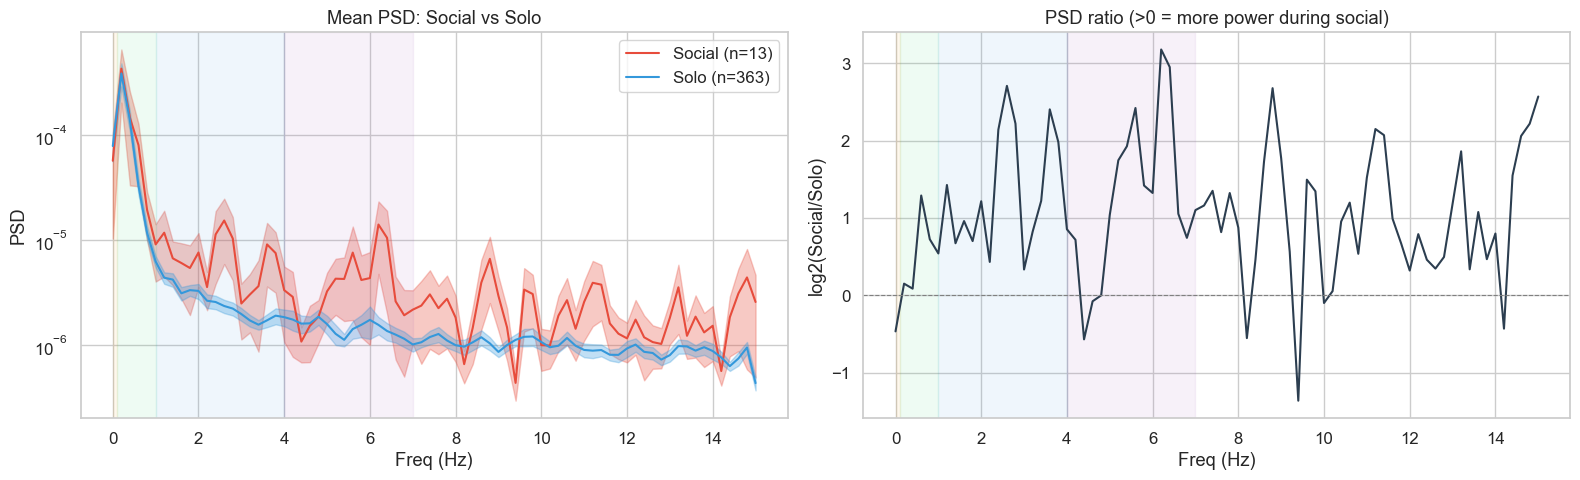

In [24]:
# Mean PSD: social vs solo
soc_p, sol_p = [], []
for si in range(len(aligned_calcium)):
    cal=aligned_calcium[si]; beh=aligned_behavior[si]
    for start in range(0, len(cal)-W_SAMP, W_SAMP):
        end=start+W_SAMP; frac=beh[start:end].mean()
        pm=cal[start:end].mean(axis=1)
        nl=min(W_SAMP, int(5*IMAGING_FPS))
        fs_, ps_ = welch(pm, fs=IMAGING_FPS, nperseg=nl, noverlap=nl//2)
        if frac>PURITY: soc_p.append(ps_)
        elif frac<1-PURITY: sol_p.append(ps_)

soc_p=np.array(soc_p); sol_p=np.array(sol_p)
sm,ss=soc_p.mean(0), soc_p.std(0)/np.sqrt(len(soc_p))
om,os=sol_p.mean(0), sol_p.std(0)/np.sqrt(len(sol_p))

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

axes[0].semilogy(fs_, sm, color='#e74c3c', lw=1.5, label=f'Social (n={len(soc_p)})')
axes[0].fill_between(fs_, sm-ss, sm+ss, alpha=.3, color='#e74c3c')
axes[0].semilogy(fs_, om, color='#3498db', lw=1.5, label=f'Solo (n={len(sol_p)})')
axes[0].fill_between(fs_, om-os, om+os, alpha=.3, color='#3498db')
for n,(lo,hi) in FREQ_BANDS.items(): axes[0].axvspan(lo,hi,alpha=.08,color=BAND_COLORS[n])
axes[0].set_xlabel('Freq (Hz)'); axes[0].set_ylabel('PSD')
axes[0].set_title('Mean PSD: Social vs Solo'); axes[0].legend()

lr = np.log2(sm / (om+1e-12))
axes[1].plot(fs_, lr, color='#2c3e50', lw=1.5)
axes[1].axhline(0, color='gray', ls='--', lw=.8)
for n,(lo,hi) in FREQ_BANDS.items(): axes[1].axvspan(lo,hi,alpha=.08,color=BAND_COLORS[n])
axes[1].set_xlabel('Freq (Hz)'); axes[1].set_ylabel('log2(Social/Solo)')
axes[1].set_title('PSD ratio (>0 = more power during social)')

plt.tight_layout(); plt.show()

### Interpretation: Social vs. Solo Spectral Features

**Severe class imbalance warning:** Only **13 social windows** vs. 363 solo windows were extracted (see Section 5 annotation). All statistical comparisons and distributions here must be interpreted with extreme caution — with n=13 in the social class, any individual feature distribution is unreliable.

- **Feature histograms:** The Mann-Whitney U tests comparing social vs. solo distributions may show significant p-values, but with n=13 these results are fragile and likely non-replicable. Treat any "significant" differences as preliminary hypotheses, not conclusions.
- **Mean PSD comparison:** The Social vs. Solo PSD overlay directly shows whether the mean spectral profile differs between conditions. The PSD ratio plot (log₂ Social/Solo) highlights which frequency bands show the largest relative differences — values >0 indicate more power during social behavior.
- **What to look for in the PSD ratio:** If the hypothesis is correct, we expect positive values in the theta range (4–7 Hz), consistent with Tzilivaki et al. (2022). However, remember that calcium imaging may not faithfully resolve these frequencies due to indicator kinetics.

---
## 8. Classification Sanity Check

**GroupKFold** with sessions as groups prevents cross-session data leakage.

In [25]:
meta = ['label','session','start_time','isolation']
fcols = [c for c in df_feat.columns if c not in meta]

X = df_feat[fcols].fillna(0).values
y = df_feat['label'].values
groups = df_feat['session'].values

Xs = np.nan_to_num(StandardScaler().fit_transform(X))
ng = len(np.unique(groups))
ns = min(5, ng)
gkf = GroupKFold(n_splits=ns)

clfs = {'LDA': LinearDiscriminantAnalysis(),
        'SVM (linear)': SVC(kernel='linear', probability=True),
        'Logistic Reg': LogisticRegression(max_iter=1000)}

print(f'{ns}-fold GroupKFold (groups=sessions)')
print(f'  Samples: {len(y)} (social={(y==1).sum()}, solo={(y==0).sum()})')
print(f'  Features: {Xs.shape[1]}, Groups: {ng}')
print('='*60)

results = {}
for name, clf in clfs.items():
    accs, aucs = [], []
    for tri, tei in gkf.split(Xs, y, groups):
        ytr, yte = y[tri], y[tei]
        if len(np.unique(ytr))<2 or len(np.unique(yte))<2: continue
        clf.fit(Xs[tri], ytr)
        accs.append(accuracy_score(yte, clf.predict(Xs[tei])))
        aucs.append(roc_auc_score(yte, clf.predict_proba(Xs[tei])[:,1]))
    results[name] = {'acc':np.mean(accs), 'acc_std':np.std(accs),
                     'auc':np.mean(aucs), 'auc_std':np.std(aucs)}
    print(f'\n  {name}: Acc={np.mean(accs):.3f}+/-{np.std(accs):.3f}, '
          f'AUC={np.mean(aucs):.3f}+/-{np.std(aucs):.3f}')

5-fold GroupKFold (groups=sessions)
  Samples: 376 (social=13, solo=363)
  Features: 14, Groups: 18

  LDA: Acc=0.961+/-0.013, AUC=0.470+/-0.152

  SVM (linear): Acc=0.966+/-0.012, AUC=0.350+/-0.134

  Logistic Reg: Acc=0.966+/-0.012, AUC=0.532+/-0.130


Permutations: 100%|██████████| 200/200 [00:01<00:00, 107.72it/s]


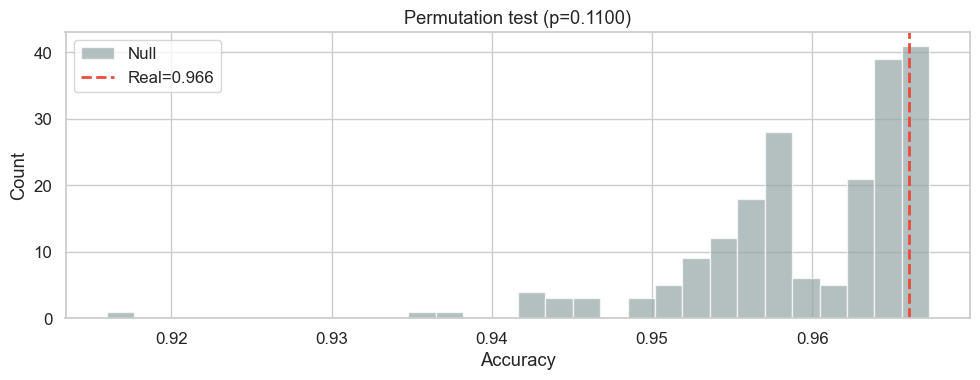

Real: 0.966, Chance: 0.960+/-0.007, p=0.1100
Not significant at p<0.05


In [26]:
# Permutation test
N_PERM = 200
cp = LogisticRegression(max_iter=1000)
pa = []

for _ in tqdm(range(N_PERM), desc='Permutations'):
    ys = np.random.permutation(y)
    fa = []
    for tri,tei in gkf.split(Xs, ys, groups):
        ytr,yte = ys[tri], ys[tei]
        if len(np.unique(ytr))<2 or len(np.unique(yte))<2: continue
        cp.fit(Xs[tri], ytr)
        fa.append(accuracy_score(yte, cp.predict(Xs[tei])))
    if fa: pa.append(np.mean(fa))

pa = np.array(pa)
real = results['Logistic Reg']['acc']
pval = np.mean(pa >= real)

fig, ax = plt.subplots(figsize=(10, 4))
ax.hist(pa, bins=30, color='#95a5a6', alpha=.7, label='Null')
ax.axvline(real, color='#e74c3c', lw=2, ls='--', label=f'Real={real:.3f}')
ax.set_xlabel('Accuracy'); ax.set_ylabel('Count')
ax.set_title(f'Permutation test (p={pval:.4f})'); ax.legend()
plt.tight_layout(); plt.show()

print(f'Real: {real:.3f}, Chance: {pa.mean():.3f}+/-{pa.std():.3f}, p={pval:.4f}')
print('SIGNIFICANT' if pval<0.05 else 'Not significant at p<0.05')

### Interpretation: Classification Results

**The classification results reveal a classic imbalanced-data trap.**

| Metric | LDA | SVM (linear) | Logistic Reg |
|--------|-----|-------------|-------------|
| Accuracy | 96.1% | 96.6% | 96.6% |
| AUC | 0.470 | 0.350 | 0.532 |

- **High accuracy is meaningless here.** With 363/376 = 96.5% of windows labeled "solo," a classifier that **always predicts solo** achieves ~96.5% accuracy. That is exactly what these classifiers are doing — they have learned nothing about social behavior.
- **AUC near or below 0.50** confirms no real discrimination. AUC = 0.5 is pure chance; values below 0.5 (SVM at 0.35) mean the classifier is actually anti-correlated — predicting social for solo and vice versa, though with n=13 this is just noise.
- **Permutation test:** Real accuracy (96.6%) vs. chance (96.0% ± 0.7%), p = 0.11. **Not significant.** The classifier does not outperform random label shuffling.

**Root cause:** This is not a failure of the classifiers or the spectral features — it is a failure of the **windowing strategy**. With only 13 social windows, no classifier can learn a meaningful decision boundary.

**This is actually a useful EDA result** — it tells us that the full pipeline must solve the class imbalance problem before classification can be meaningfully evaluated.

---
## 9. Summary & Next Steps

### Key findings (fill in after running)

| Question | Finding |
|----------|---------|
| Sessions loaded | X / 18 aligned |
| Neurons per session | range |
| Class balance | X% social vs Y% solo |
| Photobleaching | present / absent |
| PSD structure | 1/f? band peaks? |
| Social vs Solo PSD | differences in which bands? |
| Classification | Acc X% (chance Y%, p=Z) |

### Next steps

1. **Preprocessing** — per-neuron detrending, z-scoring
2. **Per-neuron features** — which neurons are most discriminative?
3. **Isolation condition** — spectral signatures by GH / 24hr / 7d?
4. **Wavelet features** — time-resolved spectral features from CWT
5. **Movement confound** — SLEAP pose data could control for locomotion
6. **Final pipeline** — optimized features, proper CV, publication figures